<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Transformer_Captioning_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Transformers
src: https://www.kaggle.com/code/mobarakol/e2e-transformer-image-captioning-example

This notebook is an example on how to generate text from images using transformers. For the encoder part, I draw inspiration from [ViT](https://arxiv.org/abs/2010.11929), while the decoder is an autoregressive generator similar to GPT. To illustrate the model, we will generate captions using the toy dataset MNIST. Instead of classifying the digits, the name will be generated.

In [ ]:
!pip -q install pytorch_lightning

     |████████████████████████████████| 798 kB 3.8 MB/s 
     |████████████████████████████████| 125 kB 9.8 MB/s 
     |████████████████████████████████| 512 kB 15.0 MB/s 
     |████████████████████████████████| 87 kB 6.3 MB/s 


In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

The Dataset class will give us pairs of images and the corresponding caption. A 1 is added at the beggining of the caption and a 2is appended at the end. We will use this values for training, indicating the start and end of the caption, respectively. For simplicity, we pad the captions to the maximum length to be able to batch examples

The DataModule will handle data preparation, tokenization and caption generation. We use a small vocab with all the possible letters in lower case. Each label in the MNIST dataset is replaced by the name of the digit, in Spanish.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_len=8):
        self.X = X 
        self.y = y 
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = torch.tensor(self.X[ix]).float().view(1, 28, 28)
        # use 1 for start of sentence
        # use 2 for end of sentence
        caption = torch.tensor([1] + self.y[ix] + [2]).long()
        # use 0 for pad
        caption = F.pad(caption, (0, self.max_len - len(caption)), 'constant', 0)
        return img, caption

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size = 1024):
        super().__init__()
        self.batch_size = batch_size
        self.vocab = 'abcdefghijklmnopqrstuvwxyz'
        self.len_vocab = len(self.vocab) + 3

    def number2caption(self, ix):
        if ix == 0: return 'cero'
        if ix == 1: return 'uno'
        if ix == 2: return 'dos'
        if ix == 3: return 'tres'
        if ix == 4: return 'cuatro'
        if ix == 5: return 'cinco'
        if ix == 6: return 'seis'
        if ix == 7: return 'siete'
        if ix == 8: return 'ocho'
        if ix == 9: return 'nueve'
        
    def caption2ixs(self, caption):
        return [self.vocab.index(c) + 3 for c in caption]

    def ixs2caption(self, ixs):
        return ('').join([self.vocab[ix - 3] for ix in ixs if ix not in [0, 1, 2]])

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"].values, mnist["target"].values.astype(np.int)
        # generate captions
        captions = [self.number2caption(ix) for ix in y]
        encoded = [self.caption2ixs(caption) for caption in captions]
        # train / val splits
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., encoded[:60000], encoded[60000:]
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, pin_memory=True)

<ipython-input-4-c7c553c9a41f>:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, y = mnist["data"].values, mnist["target"].values.astype(np.int)


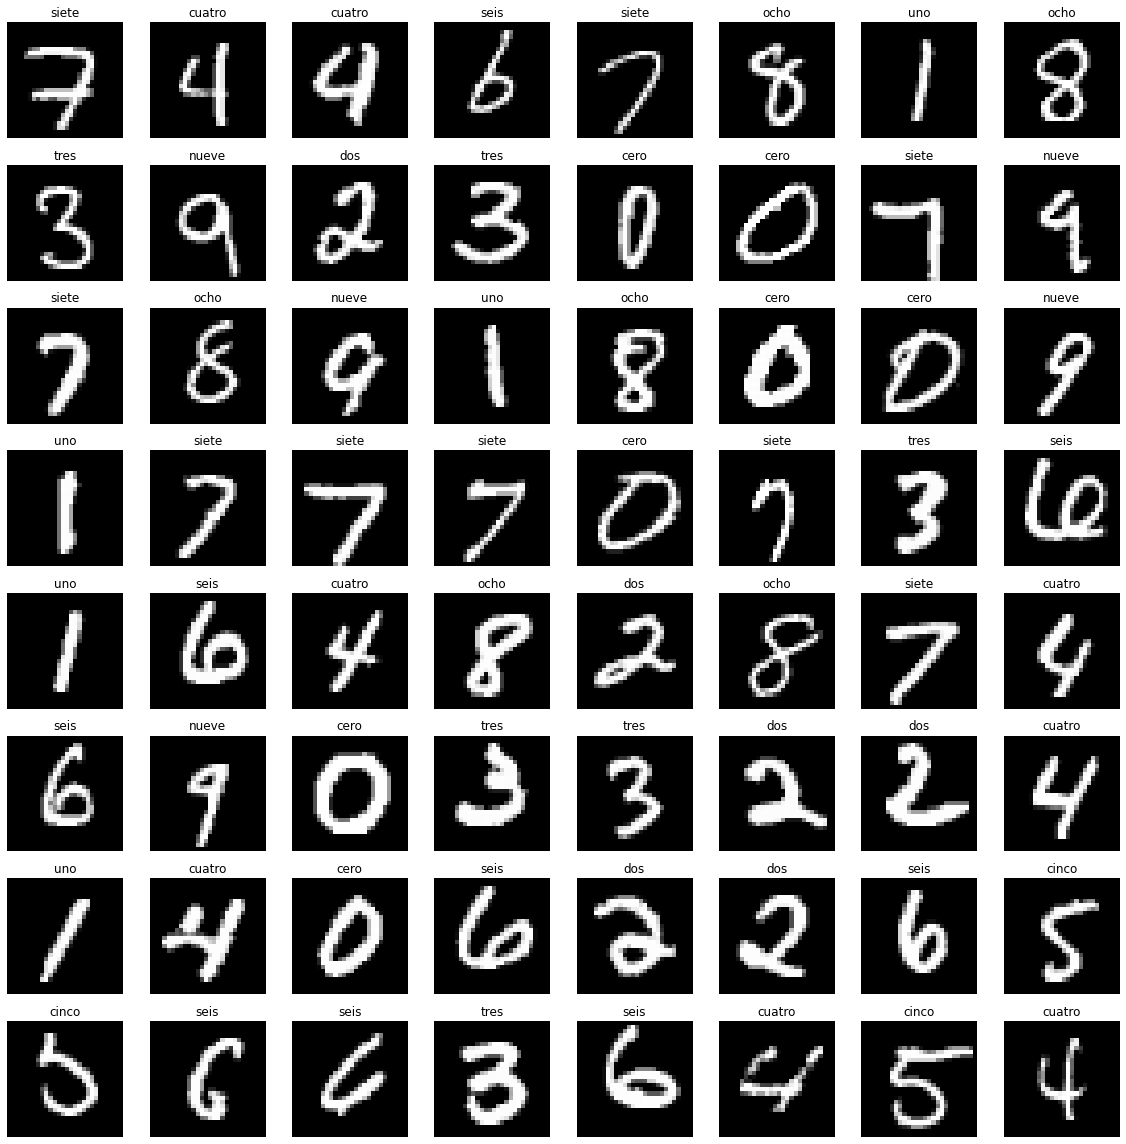

In [ ]:
dm = MNISTDataModule(batch_size=64)
dm.setup()
imgs, captions = next(iter(dm.train_dataloader()))
imgs.shape, captions.shape
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        ax.set_title(label)
plt.tight_layout()
plt.show()

# Transformer Architecture
Now into the model. The inputs to the encoder will be the images re-project, in a patched fashion, to the embedding dimension. You can find more about this in the [ViT](https://arxiv.org/abs/2010.11929) paper.

The model is a Pytorch Transformer that takes images and generates captions. Each image is tiled and reprojected as mentioned before, and fed to the encoder. The decoder is masked so it can only attend to past tokens. Finally, we use a linear classifier on top of the decoder to output a probability distribution over the vocabulary for each generated word.

<img src=https://github.com/milkymap/transformer-image-captioning/raw/main/static/cptr_architecture.jpg>

In [ ]:
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

class Model(pl.LightningModule):

    def __init__(self, 
                 len_vocab,
                 img_size=28, 
                 patch_size=7, 
                 in_chans=1, 
                 embed_dim=100, 
                 max_len=8, 
                 nhead=2, 
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                ):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        
        self.trg_emb = nn.Embedding(len_vocab, embed_dim)
        self.trg_pos_emb = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len

        self.transformer = torch.nn.Transformer(
            embed_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout
        )
        
        self.l = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, len_vocab)

    def forward(self, images, captions):
        # embed images
        embed_imgs = self.patch_embed(images)
        embed_imgs = embed_imgs + self.pos_embed  
        # embed captions
        B, trg_seq_len = captions.shape 
        trg_positions = (torch.arange(0, trg_seq_len).expand(B, trg_seq_len).to(self.device))
        embed_trg = self.trg_emb(captions) + self.trg_pos_emb(trg_positions)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(self.device)
        tgt_padding_mask = captions == 0
        # transformer
        y = self.transformer(
            embed_imgs.permute(1,0,2),  
            embed_trg.permute(1,0,2),  
            tgt_mask=trg_mask, 
            tgt_key_padding_mask = tgt_padding_mask
        ).permute(1,0,2) 
        # head
        return self.fc(self.l(y))

    def predict(self, images):
        self.eval()
        with torch.no_grad():
            images = images.to(self.device)
            B = images.shape[0]
            eos = torch.tensor([1], dtype=torch.long, device=self.device).expand(B, 1)
            trg_input = eos
            for _ in range(self.max_len):
                preds = self(images, trg_input)
                preds = torch.argmax(preds, axis=2)
                trg_input = torch.cat([eos, preds], 1)
            return preds
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x, y[:,:-1])
        trg_output = y[:,1:] 
        loss = F.cross_entropy(y_hat.permute(0,2,1), trg_output) 
        # I know this is not the best metric...
        acc = (torch.argmax(y_hat, axis=2) == trg_output).sum().item() / (trg_output.shape[0]*trg_output.shape[1])
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

#Training

In [ ]:
dm = MNISTDataModule()
model = Model(dm.len_vocab)
trainer = pl.Trainer(max_epochs=10, gpus=1, precision=16)
trainer.fit(model, dm)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-4-c7c553c9a41f>:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


#Prediction

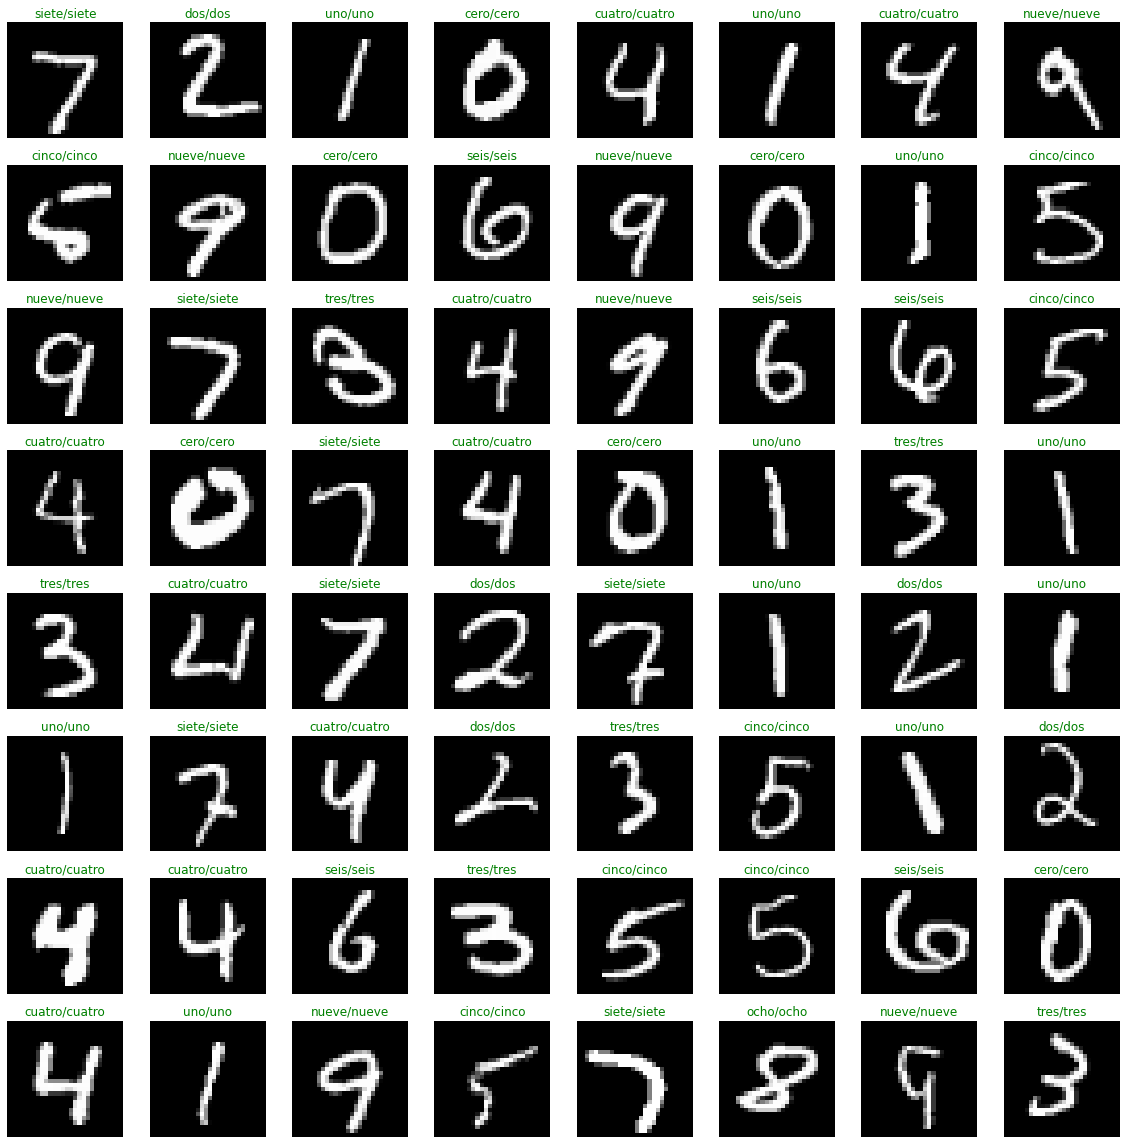

In [ ]:
imgs, captions = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        pred = dm.ixs2caption(preds[ix])
        ax.set_title(label)
        ax.set_title(f'{label}/{pred}', color="green" if label == pred else 'red')
plt.tight_layout()
plt.show()